In [1]:
import sys, numpy as np, matplotlib.pyplot as plt, networkx as nx
from matplotlib import style
sys.path.insert(0, '../')
style.use('seaborn-poster')
from Models.fastIsing import Ising


n, p = 10, .3
g = nx.erdos_renyi_graph(n, p)
settings = dict(\
               graph = g,\
               updateType = 'single',\
               nudgeType  = 'constant',\
               )

m = Ising(**settings)

temps = np.logspace(-4, np.log10(m.nNodes), 500)
data  = np.asarray([m.matchMagnetization(temps, 100) for i in range(3)]).mean(0)
from scipy.ndimage import gaussian_filter1d
mag, sus = gaussian_filter1d(data, 3, axis = 1)
# mag, sus = data


 41%|████      | 204/500 [00:00<00:00, 1164.26it/s]

Computing mag per t


 40%|███▉      | 198/500 [00:00<00:00, 1051.32it/s]

Computing mag per t


 38%|███▊      | 188/500 [00:00<00:00, 1173.79it/s]

Computing mag per t


100%|██████████| 500/500 [00:00<00:00, 834.25it/s] 


/home/casper/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':


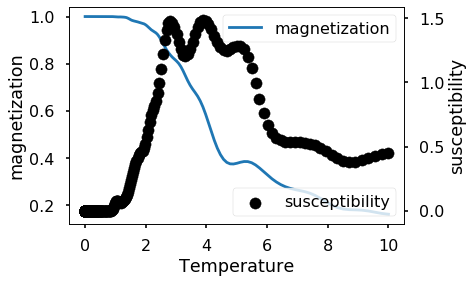

In [2]:
# magnetization plot
fig, ax = plt.subplots()
tax = ax.twinx()
tax.scatter(temps, sus, color = 'black', label = 'susceptibility')
ax.plot(temps, mag, label = 'magnetization')
ax.set(xlabel = 'Temperature', ylabel = 'magnetization')
tax.set(ylabel = 'susceptibility')
tax.legend(loc = 'lower right'); ax.legend()
fig.show()

/home/casper/miniconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/casper/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  This is separate from the ipykernel package so we can avoid doing imports until


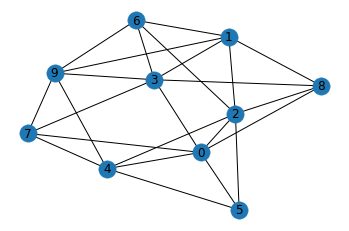

In [3]:
fig, ax = plt.subplots()
nx.draw(g, ax = ax, with_labels = 1)
fig.show()

In [5]:
# compute mi over time
from Toolbox import infcy as information
nSamples = int(3e4)
step     = 1000
repeats  = int(1e4)
deltas   = 100

idx = np.argmin(abs(mag - .85 * mag.max()))
m.t = temps[idx]
snapshots = information.getSnapShots(m, nSamples, step)
conditional, px, mi = information.runMC(m, snapshots, deltas, repeats)


 23%|██▎       | 6765/30000 [00:02<00:16, 1416.88it/s]


 41%|████      | 12314/30000 [00:03<00:08, 1999.79it/s]


 62%|██████▏   | 18722/30000 [00:05<00:05, 2087.31it/s]


 81%|████████  | 24181/30000 [00:07<00:02, 1991.99it/s]


  0%|          | 0/654 [00:00<?, ?it/s]

done
Found 654 states
Delta =  10.17 sec
Decoding..
starting runs



 37%|███▋      | 239/654 [00:39<00:53,  7.77it/s]


 79%|███████▊  | 515/654 [01:20<00:29,  4.64it/s]


100%|██████████| 654/654 [01:43<00:00,  6.34it/s]

Delta =  103.13 sec


/home/casper/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log2
  # This is added back by InteractiveShellApp.init_path()
/home/casper/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in multiply
  # This is added back by InteractiveShellApp.init_path()


/home/casper/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


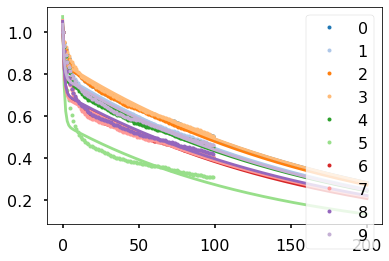

In [6]:
from Utils.plotting import fit

colors = plt.cm.tab20(range(m.nNodes))
params = dict(\
             bounds = (0, np.inf),\
             jac = 'cs')
func = lambda x, a, b, c, d, e, f:  b * np.exp(-c * (x - f)) + d * np.exp(- (x - e) ) 
# func = lambda x, a, b: 
coeffs, _  = fit(mi.T, func, params = params)


x = np.linspace(0, 2 * deltas, 200)

fig, ax = plt.subplots()
for k, v in m.mapping.items():
    ax.plot(mi[:, v], linestyle = 'none', marker = 'o', markersize = 4, label = k, color = colors[v])
    ax.plot(x, func(x, *coeffs[v]), color = colors[v])
# ax.set(yscale = 'log', xscale = 'log')
ax.legend()
fig.show()

In [7]:
import scipy
aucs = np.asarray([\
                  scipy.integrate.quad(lambda x: func(x, *c), 0, np.inf)[0]\
                   for c in coeffs\
                  ])
for k, v in m.mapping.items():
    print(f'Node {k} had {aucs[v]}')

Node 0 had 155.19669305263196
Node 1 had 138.3709485247995
Node 2 had 149.46867761555865
Node 3 had 155.35627940231583
Node 4 had 134.29902714559748
Node 5 had 78.73169560558094
Node 6 had 115.83340436970119
Node 7 had 119.67606234260023
Node 8 had 122.55266907510992
Node 9 had 135.90680991345218


In [ ]:
from Utils import stats

nudges = np.logspace(-3, 1, 10)

TARGET = m.rmapping[np.argmax(aucs)]
sensitivity = np.zeros((nudges.size, m.nNodes, deltas))
for idx, nudge in enumerate(nudges):
    for node, nidx in m.mapping.items():
        tmp = {node : nudge}
        m.nudges = tmp
        cpx, p, cmi = information.runMC(m, snapshots, deltas, repeats)
        tmp = stats.JS(px, p).sum(-1)
        sensitivity[idx, nidx] = tmp
    


  0%|          | 0/654 [00:00<?, ?it/s]

Decoding..
starting runs



 41%|████      | 265/654 [00:36<00:58,  6.65it/s]


 79%|███████▉  | 518/654 [01:11<00:26,  5.15it/s]


100%|██████████| 654/654 [01:29<00:00,  7.66it/s]/home/casper/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log2
  # This is added back by InteractiveShellApp.init_path()
/home/casper/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in multiply
  # This is added back by InteractiveShellApp.init_path()

  0%|          | 0/654 [00:00<?, ?it/s]

Delta =  89.28 sec
Decoding..
starting runs



 44%|████▎     | 286/654 [00:38<00:57,  6.42it/s]


 82%|████████▏ | 537/654 [01:12<00:16,  7.13it/s]


  0%|          | 0/654 [00:00<?, ?it/s]

Delta =  89.20 sec
Decoding..
starting runs



 44%|████▍     | 291/654 [00:40<00:54,  6.64it/s]


 81%|████████▏ | 533/654 [01:14<00:18,  6.48it/s]


  0%|          | 0/654 [00:00<?, ?it/s]

Delta =  91.98 sec
Decoding..
starting runs



 41%|████▏     | 271/654 [00:37<00:45,  8.50it/s]


 84%|████████▍ | 552/654 [01:15<00:14,  7.14it/s]


  0%|          | 0/654 [00:00<?, ?it/s]

Delta =  90.14 sec
Decoding..
starting runs



 40%|████      | 263/654 [00:36<00:54,  7.23it/s]


 80%|███████▉  | 520/654 [01:14<00:21,  6.33it/s]


  0%|          | 0/654 [00:00<?, ?it/s]

Delta =  93.37 sec
Decoding..
starting runs



 42%|████▏     | 273/654 [00:35<00:55,  6.83it/s]


 86%|████████▋ | 565/654 [01:12<00:13,  6.36it/s]


  0%|          | 0/654 [00:00<?, ?it/s]

Delta =  85.47 sec
Decoding..
starting runs



 43%|████▎     | 283/654 [00:39<01:05,  5.65it/s]


 84%|████████▎ | 547/654 [01:15<00:18,  5.69it/s]


  0%|          | 0/654 [00:00<?, ?it/s]

Delta =  89.17 sec
Decoding..
starting runs



 46%|████▌     | 298/654 [00:37<00:37,  9.45it/s]


 87%|████████▋ | 566/654 [01:11<00:14,  6.08it/s]


  0%|          | 0/654 [00:00<?, ?it/s]

Delta =  84.89 sec
Decoding..
starting runs



 40%|████      | 263/654 [00:37<01:12,  5.36it/s]


 79%|███████▊  | 514/654 [01:14<00:23,  5.95it/s]


  0%|          | 0/654 [00:00<?, ?it/s]

Delta =  94.46 sec
Decoding..
starting runs



 43%|████▎     | 282/654 [00:39<00:52,  7.14it/s]


 82%|████████▏ | 534/654 [01:15<00:17,  6.72it/s]


  0%|          | 0/654 [00:00<?, ?it/s]

Delta =  93.07 sec
Decoding..
starting runs



 46%|████▋     | 304/654 [00:42<00:59,  5.92it/s]


 84%|████████▍ | 552/654 [01:17<00:22,  4.60it/s]


  0%|          | 0/654 [00:00<?, ?it/s]

Delta =  92.74 sec
Decoding..
starting runs



 42%|████▏     | 277/654 [00:39<01:04,  5.83it/s]


 80%|███████▉  | 520/654 [17:26:58<00:26,  5.07it/s]


  0%|          | 0/654 [00:00<?, ?it/s]

Delta =  102.65 sec
Decoding..
starting runs



  3%|▎         | 22/654 [00:03<01:29,  7.08it/s]

In [ ]:
fig, ax = plt.subplots()
ax.plot(sensitivity.T)
fig.show()


fig, ax = plt.subplots()
y = np.trapz(sensitivity[:, deltas // 2:], axis = -1)
ax.errorbar(nudges, y)
ax.scatter(nudges, y)
ax.set(yscale = 'log', xscale = 'linear',\
      xlabel = 'nudge size', ylabel = 'causal impact',\
      title = 'nudge effect on largest informational impact')
print(m.t)
fig.show()